# Univariate Time Series Prediction and Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Loading Dataset

In [2]:
# wrangle function
def wrangle(filepath):
    # Read csv file into Data Frame
    df = pd.read_csv(filepath)
    # Clean column names
    df = df.rename(columns=lambda x: x.strip().strip('"'))

    # Rename columns
    df['pilotstate'] = df['pilotstate(EV_DISCONNECTED = \'A\'_EV_CONNECTED = \'B1\'_WAITING_FOR_EV = \'B2\'_STOP_MODE = \'C1\'_CHARGING_MAX_POWER = \'C2\'_FAULT_RESTART = \'F\'']
    df['loadcontrolgridimportexport-n'] = df['zappimode(1=FAST.2=ECO.3=ECO+)']
    df['zappimode'] = df[')']
    df['dsrdataload-n'] = df['loadcontrolgridimportexport']
    df['dsrdataseconds-n'] = df['dsrdataload']

    # Drop redundant columns
    df.drop(columns=['pilotstate(EV_DISCONNECTED = \'A\'_EV_CONNECTED = \'B1\'_WAITING_FOR_EV = \'B2\'_STOP_MODE = \'C1\'_CHARGING_MAX_POWER = \'C2\'_FAULT_RESTART = \'F\'',
            'zappimode(1=FAST.2=ECO.3=ECO+)', 'loadcontrolgridimportexport', 'dsrdataload', 'dsrdataseconds', ')'], inplace=True)

    # Convert time format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

In [3]:
data = wrangle('./Data/chargerdata2_2023_06_10_Anonymized.csv')
data

,id,power,dsrloadcontrolactive,voltage,frequency,chargeenergy,pilotstate,loadcontrolgridimportexport-n,zappimode,dsrdataload-n,dsrdataseconds-n
timestamp,,,,,,,,,,,
2023-05-01 16:25:12,1,0,False,2389,4997,18.20,A,898,FAST,0,0
2023-05-01 16:25:12,2,0,False,2419,4994,36.53,A,-2219,FAST,0,0
2023-05-01 16:25:12,3,0,False,2408,4995,24.28,A,400,FAST,0,0
2023-05-01 16:25:12,4,0,False,2399,4988,17.44,A,-4,ECO_PLUS,0,0
2023-05-01 16:25:12,5,0,False,2385,4993,4.53,NaN,-4,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01 16:25:12,33,0,False,2334,4995,18.97,A,420,FAST,0,0
2023-05-01 16:25:12,34,1148,False,2219,4995,1.21,C2,325,ECO_PLUS,0,0
2023-05-01 16:25:12,35,0,False,2376,4996,0.00,A,30,FAST,0,0


In [4]:
#Sorting data by index in ascending order
data.sort_index(inplace=True)

### Data Selection per id (ID: 26, 12, 9)

In [5]:
# Selecting data for only id 26
df26 = data[['power']][data.id == 26]

# Selecting data for only id 12
df12 = data[['power']][data.id == 12]

# Selecting data for only id 9
df9 = data[['power']][data.id == 9]

### Plots

array([<AxesSubplot:xlabel='timestamp'>], dtype=object)

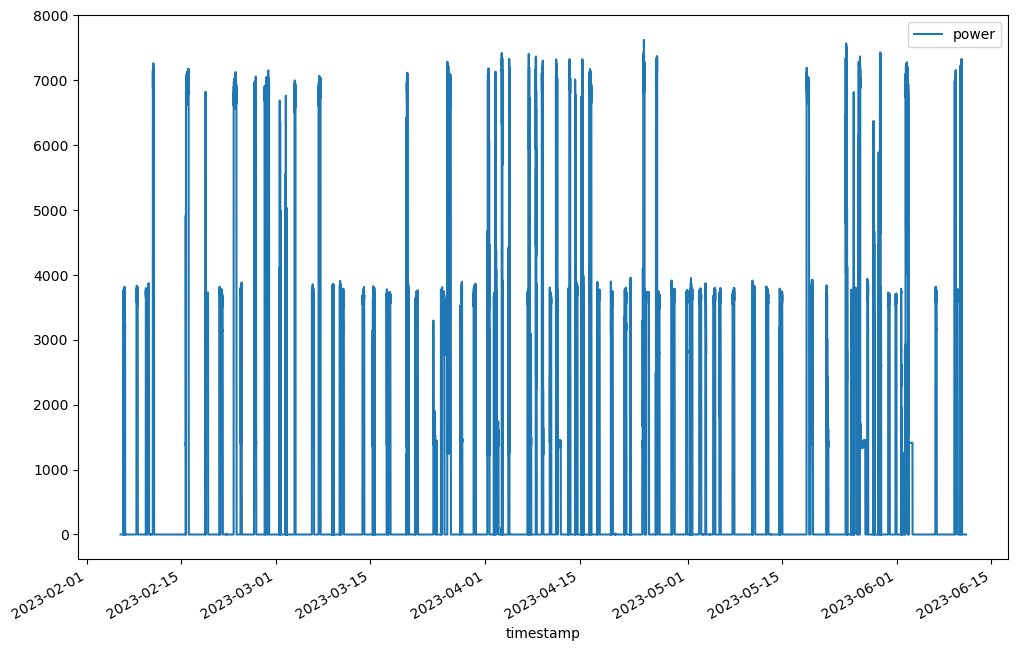

In [8]:
df9.plot(figsize=(12,8), subplots=True)

array([<AxesSubplot:xlabel='timestamp'>], dtype=object)

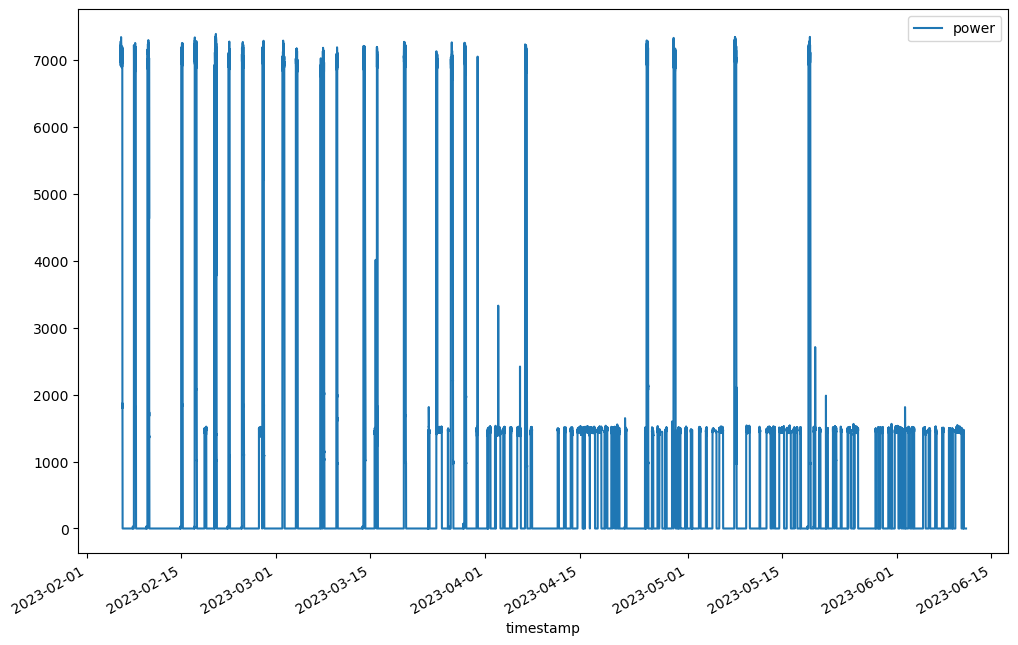

In [35]:
df12.plot(figsize=(12,8), subplots=True)

array([<AxesSubplot:xlabel='timestamp'>], dtype=object)

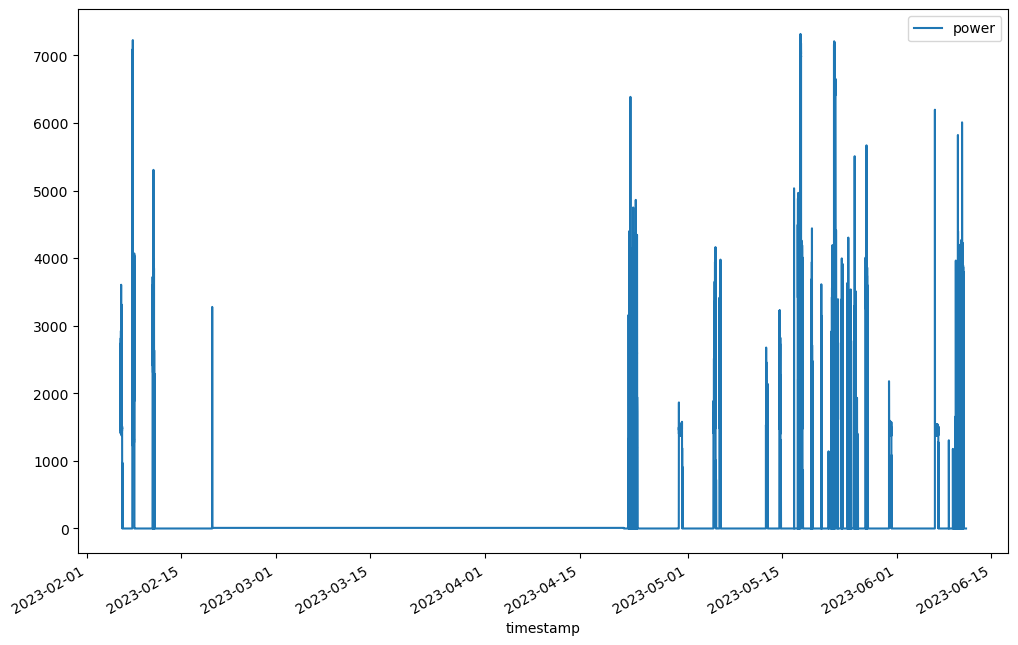

In [10]:
df26.plot(figsize=(12,8), subplots=True)

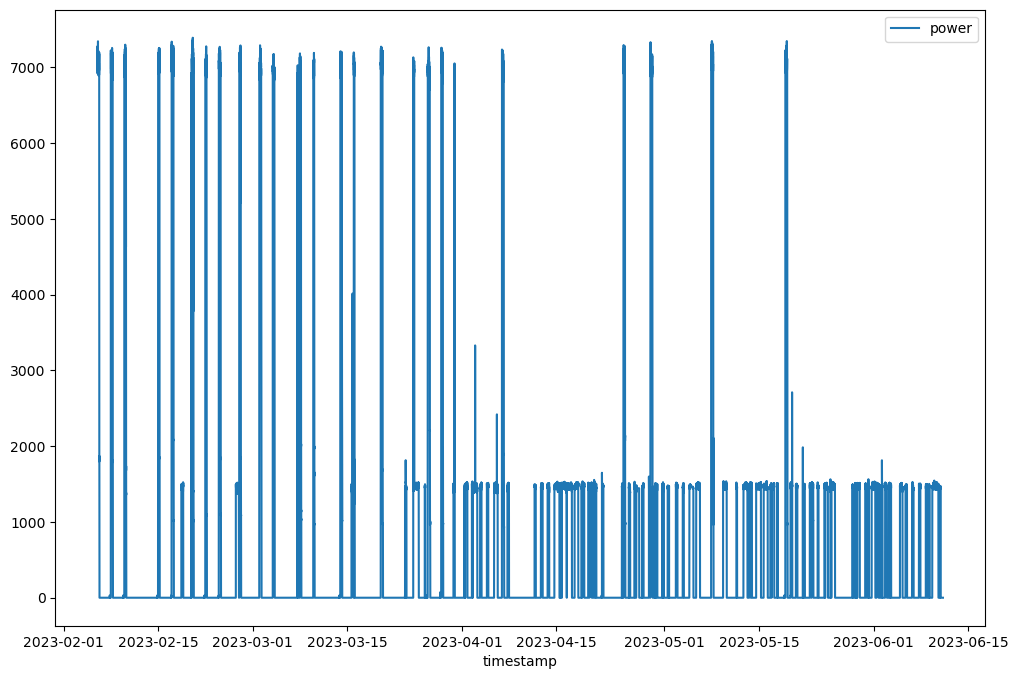

In [8]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=df12)

In [46]:
axes = ax.get_xticklabels()

[Text(19389.0, 0, '2023-02-01'),
 Text(19403.0, 0, '2023-02-15'),
 Text(19417.0, 0, '2023-03-01'),
 Text(19431.0, 0, '2023-03-15'),
 Text(19448.0, 0, '2023-04-01'),
 Text(19462.0, 0, '2023-04-15'),
 Text(19478.0, 0, '2023-05-01'),
 Text(19492.0, 0, '2023-05-15'),
 Text(19509.0, 0, '2023-06-01'),
 Text(19523.0, 0, '2023-06-15')]

## Time Series Prediction

### Data Preproccessing

In [61]:
def data_preprocess(data, minute_interval='15T', split_ratio=0.7, initialize_scale=True, scaler=None):
    
    #Refactor to 15-min interval
    df_resampled = data.resample(minute_interval).mean()
  
    # Drop null values
    df_resampled.fillna(value=0, inplace=True)

    if initialize_scale:
        #Create an instance of new scaler if no scaler is provided
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(df_resampled)

    else:
        #use provided scaler object
        df_scaled = scaler.fit_transform(df_resampled)

    # Splitting the dataset into train set and test set
    train_size = int(len(df_scaled) * split_ratio)

    train_data = df_scaled[:train_size] # Train set
    test_data = df_scaled[train_size:] # Test set

    return train_data, test_data, df_scaled, df_resampled, scaler

### Time Series Prediction on id 12

In [63]:
train_data_12, test_data_12, df12_scaled, df12_resampled, scaler = data_preprocess(df12)
train_data_12.shape, test_data_12.shape

((8420, 1), (3609, 1))

### Creating Time series with previous observations

In [79]:
# Function: Create time step for the dataset

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

In [80]:
time_step = 96 #Since for 15mins interval (4 x 24) [4x15min = 1 hr]

X_train, y_train = create_dataset(train_data_12, time_step=time_step)
X_test, y_test = create_dataset(test_data_12, time_step=time_step)

In [81]:
X_train.shape, y_train.shape

((8324, 96), (8324,))

## Modelling

### Random Forest

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [124]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Evaluating Random Forest Model

In [84]:
# Function: Calculate root mean squared error
def calculate_rmse(actual, prediction):
    mse = mean_squared_error(actual, prediction)
    rmse = np.sqrt(mse)
    return rmse

#Function Calculate mean absolute error
def calculate_mae(actual, prediction):
    mae = mean_absolute_error(actual, prediction)
    return mae

In [129]:
# Make Predictions
train_predict = forest_reg.predict(X_train) # prediction on train data
test_predict = forest_reg.predict(X_test) # prediction on test data
    
# reverse the scalar effect
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
# Calculate RMSE
print("RMSE for Train dataset", calculate_rmse(train_actual, train_predict)) # rmse for train data
print("RMSE for Test dataset", calculate_rmse(test_actual, test_predict), '\n') # rmse for test data
    
# Calculate MAE
print("MAE for Train dataset", calculate_mae(train_actual, train_predict)) # mae for train data
print("MAE for Test dataset", calculate_mae(test_actual, test_predict)) # mae for test data

RMSE for Train dataset 185.15170672887467
RMSE for Test dataset 205.31390651615567 

MAE for Train dataset 27.95096061825295
MAE for Test dataset 61.63726878616164


In [86]:
def plot_predictions(df_scaled, train_predict, test_predict, time_step, scaler):

    trainPredictPlot = np.empty_like(df_scaled)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

    testPredictPlot = np.empty_like(df_scaled)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2):len(df_scaled), :] = test_predict

    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(data=scaler.inverse_transform(df_scaled), label='Actual Trends', legend=False)
    #plt.plot(scaler.inverse_transform(df_scaled), label='Actual Trends')
    plt.plot(trainPredictPlot, label='Train Predictions')
    plt.plot(testPredictPlot, label='Test Predictions')
    ax.set_xticks(list(np.linspace(0,12000,10, dtype=int)), labels=axes)
    plt.legend()
    plt.show()

### New Plot

In [88]:
def new_plot(actual, prediction, df_resampled, num_day=0):
    
    df = df_resampled[actual.shape[0]*-1:]
    df_pred = pd.DataFrame(prediction)

    df = df.copy()
    df['predictions'] = np.array(df_pred)
    plt.figure(figsize=(12,8))

    if num_day == 0:
        plt.plot(df['power'], label='Prediction')
        plt.plot(df['predictions'], label='True Value')
    else:
        n = num_day * 96
        plt.plot(df.iloc[:n,:]['power'], label = 'Prediction')
        plt.plot(df.iloc[:n,:]['predictions'], label = 'True Value')
    
    plt.legend()
    plt.show()

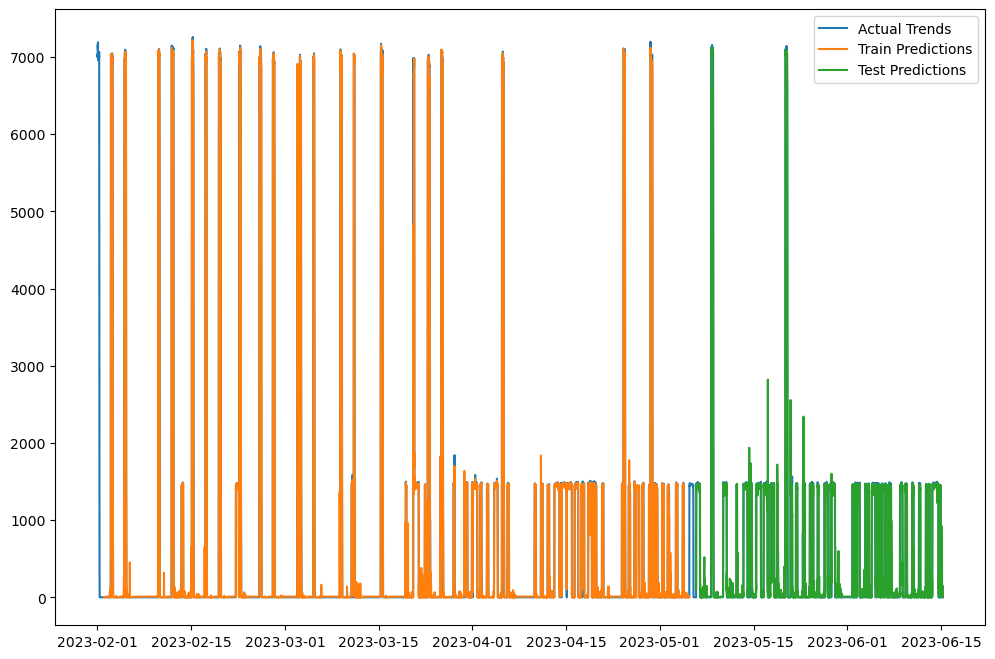

In [126]:
plot_predictions(df12_scaled, train_predict, test_predict, 96, scaler)

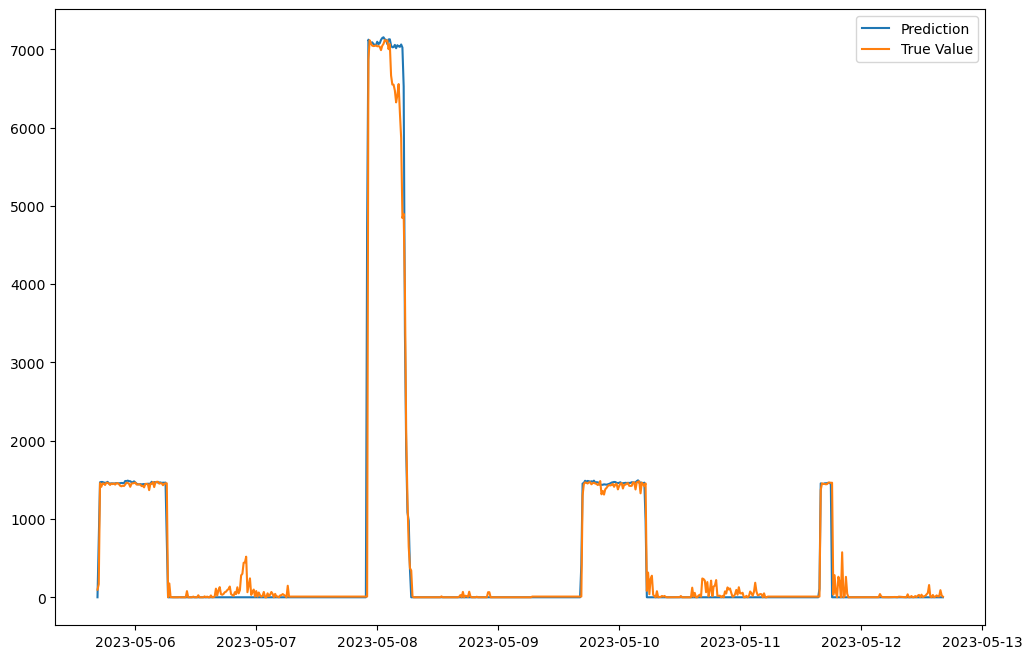

In [130]:
new_plot(test_actual, test_predict, df12_resampled, num_day=7)

### Decision Tree

In [108]:
from sklearn import tree

Dtree_reg = tree.DecisionTreeRegressor()
Dtree_reg = Dtree_reg.fit(X_train, y_train)


In [109]:
# Make Predictions
train_predict = Dtree_reg.predict(X_train) # prediction on train data
test_predict = Dtree_reg.predict(X_test) # prediction on test data
    
# reverse the scalar effect
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
# Calculate RMSE
print("RMSE for Train dataset", calculate_rmse(train_actual, train_predict)) # rmse for train data
print("RMSE for Test dataset", calculate_rmse(test_actual, test_predict), '\n') # rmse for test data
    
# Calculate MAE
print("MAE for Train dataset", calculate_mae(train_actual, train_predict)) # mae for train data
print("MAE for Test dataset", calculate_mae(test_actual, test_predict)) # mae for test data

RMSE for Train dataset 122.19757865876137
RMSE for Test dataset 262.068033199733 

MAE for Train dataset 5.275251446588746
MAE for Test dataset 50.66040125038504


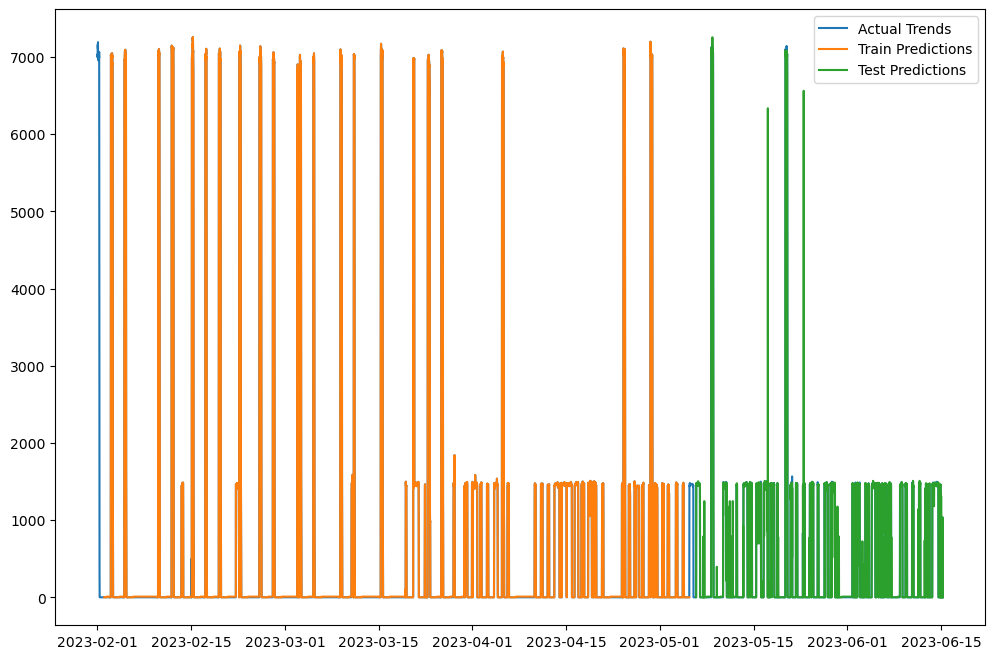

In [110]:
plot_predictions(df12_scaled, train_predict, test_predict, 96, scaler)

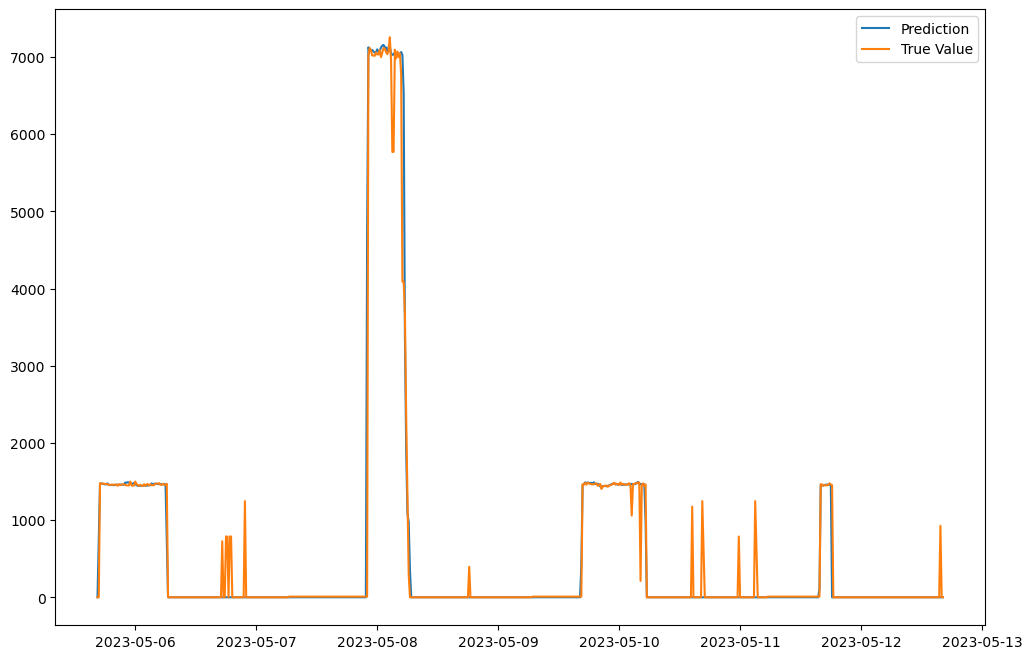

In [113]:
new_plot(test_actual, test_predict, df12_resampled, num_day=7)

### XGBoost Model

In [117]:
import xgboost as xgb

In [118]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=20)

[0]	validation_0-rmse:0.33314	validation_1-rmse:0.31418
[20]	validation_0-rmse:0.03351	validation_1-rmse:0.03004
[40]	validation_0-rmse:0.02552	validation_1-rmse:0.03065
[60]	validation_0-rmse:0.02190	validation_1-rmse:0.03085
[68]	validation_0-rmse:0.02099	validation_1-rmse:0.03087


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [119]:
# Make Predictions
train_predict = reg.predict(X_train) # prediction on train data
test_predict = reg.predict(X_test) # prediction on test data
    
# reverse the scalar effect
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
# Calculate RMSE
print("RMSE for Train dataset", calculate_rmse(train_actual, train_predict)) # rmse for train data
print("RMSE for Test dataset", calculate_rmse(test_actual, test_predict), '\n') # rmse for test data
    
# Calculate MAE
print("MAE for Train dataset", calculate_mae(train_actual, train_predict)) # mae for train data
print("MAE for Test dataset", calculate_mae(test_actual, test_predict)) # mae for test data

RMSE for Train dataset 256.566005648666
RMSE for Test dataset 216.38853987554867 

MAE for Train dataset 45.413381197546656
MAE for Test dataset 60.881336440546804


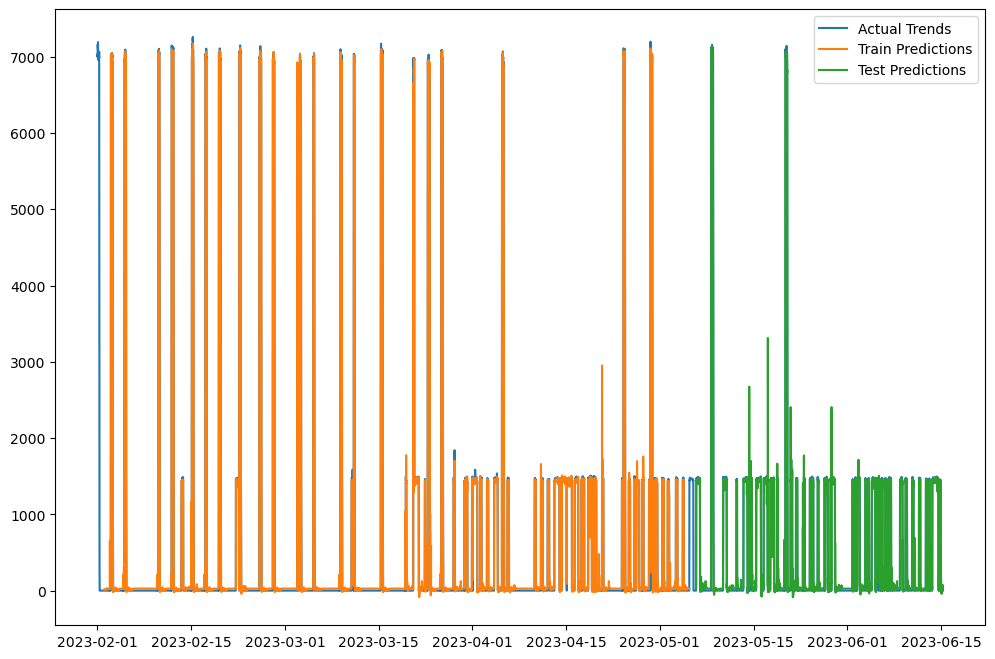

In [120]:
plot_predictions(df12_scaled, train_predict, test_predict, 96, scaler)

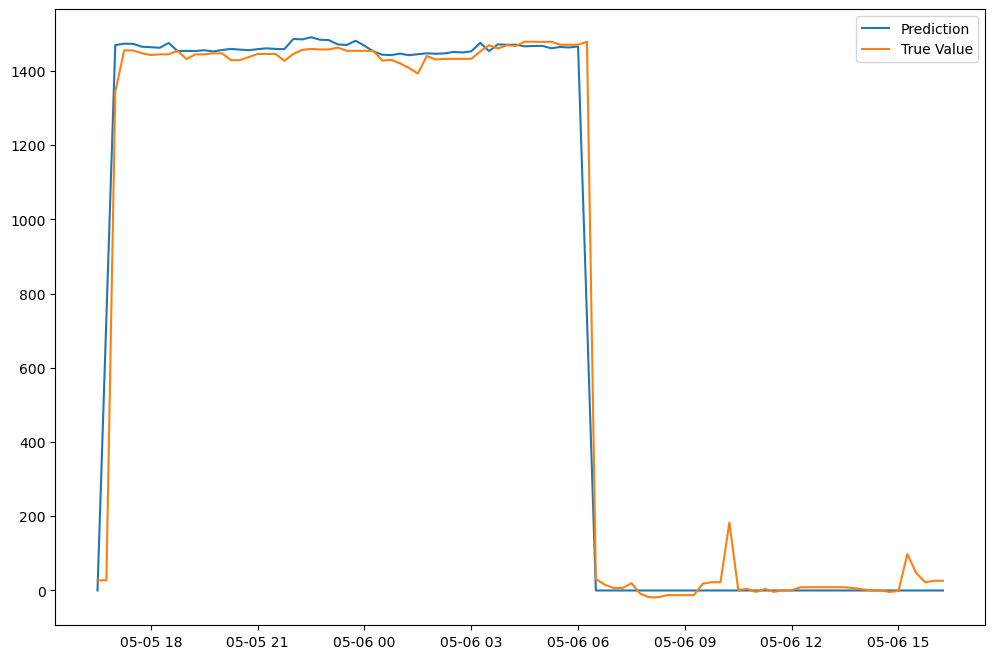

In [122]:
new_plot(test_actual, test_predict, df12_resampled, num_day=1)